In [1]:
## Visualisation for Univariate Quantile Linear Regression Model
## by Jimmy Cheung

In [2]:
## No need to carry out multiple (30) experiments and calculate RMSE, MAE, MAPE here

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

In [4]:
# Univariate data processing
def split_series(series, input_size, output_size, train_ratio, seed):
	# 1. split univariate series to input (X) and output(y)
	X, y = [], []
	for i in range(len(series) - input_size - output_size + 1):
		X.append(series[i:i+input_size]) # e.g. [10, 20, 30]
		y.append(series[i+input_size:i+input_size+output_size]) # e.g. [40, 50]
	# 2. shuffle batches and split into train/test
	X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_ratio, random_state = seed)
	return X_train, X_test, y_train, y_test

In [5]:
# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
	y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi-step ahead version
	u = y - y_pred
	loss = np.where(u >= 0, tau * u, (tau - 1) * u)
	return np.sum(loss)

In [6]:
# Lorenz
def lorenz(xyz, *, s=10, r=28, b=2.667):
	x, y, z = xyz
	x_dot = s*(y - x)
	y_dot = r*x - y - x*z
	z_dot = x*y - b*z
	return np.array([x_dot, y_dot, z_dot])

In [7]:
# DATA HANDLING

# data = 'bitcoin'
# data = 'ethereum'
# data = 'sunspots'
# data = 'mackey-glass'
data = 'lorenz'

if data == 'bitcoin' or data == 'ethereum':
    if data == 'bitcoin':
        df = pd.read_csv('../data/bitcoin.csv')
    else:
        df = pd.read_csv('../data/ethereum.csv')
    target = df.iloc[:,4].copy() # only interested in close price
elif data == 'sunspots':
    df = pd.read_csv('../data/sunspots.csv')
    target = df['Monthly Mean Total Sunspot Number']
elif data == 'mackey-glass' or data == 'lorenz':
    if data == 'mackey-glass':
        from reservoirpy.datasets import mackey_glass 
        df = mackey_glass(n_timesteps = 3000, tau=75, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
    else:
        dt = 0.01
        num_steps = 3000
        dim = 1 # x-dim: 0, y-dim: 1, z-dim: 2
        xyzs = np.empty((num_steps+1, 3))  
        xyzs[0] = (0., 1., 1.05)  
        for i in range(num_steps):
            xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
        df = xyzs[:, dim] 
    df = df.flatten()
    target = pd.Series(df, name = 'Value')
    target.index = range(len(target))

target_reshaped = np.array(target).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1)) # normalise response variable
target_scaled = scaler.fit_transform(target_reshaped).flatten()

In [8]:
quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
input_size = 6
output_size = 5
train_ratio = 0.7
seed = 5925

In [9]:
X_train, X_test, y_train, y_test = split_series(target_scaled, input_size, output_size, train_ratio, seed)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

results = {q: None for q in quantiles} # dictionary

for q in quantiles:
    # QUANTILE LINEAR REGRESSION
    initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
    result = minimize(tilted_loss, initial_beta, args = (X_train, y_train, q), method = 'BFGS')
    beta_hat = result.x.reshape(X_train.shape[1], output_size)
    y_pred_test = np.dot(X_test, beta_hat)
    results[q] = y_pred_test # shape of results is now
    # {0.05: [1021, 5], 0.25: [1021, 5], 0.5: [1021, 5], 0.75: [1021, 5], 0.95: [1021, 5]}

# Inverse transform
predicted_005 = scaler.inverse_transform(results[0.05])
predicted_025 = scaler.inverse_transform(results[0.25])
predicted_050 = scaler.inverse_transform(results[0.50])
predicted_075 = scaler.inverse_transform(results[0.75])
predicted_095 = scaler.inverse_transform(results[0.95])
actual_values = scaler.inverse_transform(y_test)

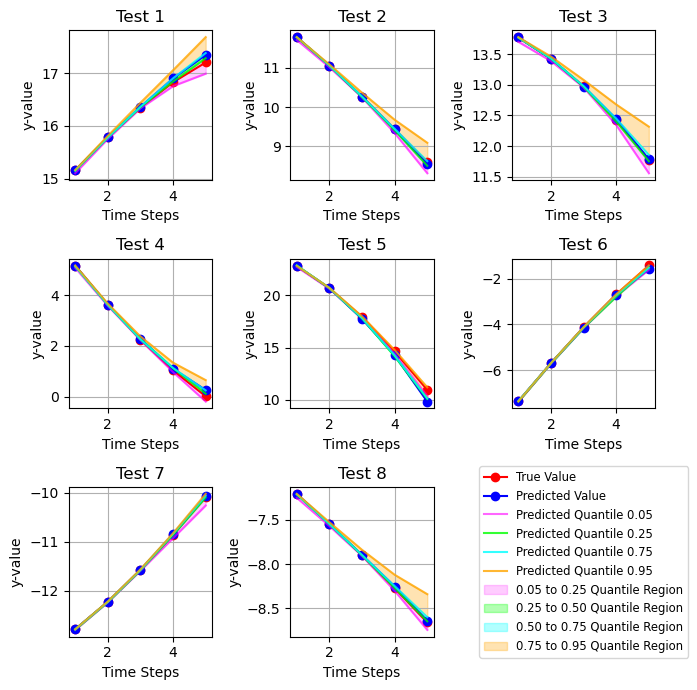

In [10]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='red', label='True Value')
    ax.plot(time_steps, predicted_050[i], marker='o', linestyle='-', color='blue', label='Predicted Value')
    
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='magenta', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='lime', label='Predicted Quantile 0.25', alpha=0.8)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='cyan', label='Predicted Quantile 0.75', alpha=0.8)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='orange', label='Predicted Quantile 0.95', alpha=0.8)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='magenta', alpha=0.2, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='lime', alpha=0.3, label='0.25 to 0.50 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='cyan', alpha=0.3, label='0.50 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='orange', alpha=0.3, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Test {i+1}')
    if data == 'bitcoin' or data == 'ethereum':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Price (USD)')
    elif data == 'sunspots':
        ax.set_xlabel('Months')
        ax.set_ylabel('Number of Sunspots')
    elif data == 'mackey-glass':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
    elif data == 'lorenz':
        ax.set_xlabel('Time Steps')
        if dim == 0:
            ax.set_ylabel('x-value')
        elif dim == 1:
            ax.set_ylabel('y-value')
        elif dim == 2:
            ax.set_ylabel('z-value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 

plt.tight_layout()

if data == 'bitcoin':
    plt.savefig('results/linear/univariate/BTC-U-QLinear.png')
elif data == 'ethereum':
    plt.savefig('results/linear/univariate/ETH-U-QLinear.png')
elif data == 'sunspots':
    plt.savefig('results/linear/univariate/Sunspots-QLinear.png')
elif data == 'mackey-glass':
    plt.savefig('results/linear/univariate/MG-QLinear.png')
elif data == 'lorenz':
    if dim == 0: # X-dim
        plt.savefig('results/linear/univariate/LorenzX-QLinear.png')
    elif dim == 1:
        plt.savefig('results/linear/univariate/LorenzY-QLinear.png')
    elif dim == 2:
        plt.savefig('results/linear/univariate/LorenzZ-QLinear.png')

plt.show()
plt.close()